In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(100)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Custom Dataset for Oxford-IIIT Pet Dataset
class OxfordPetDataset(Dataset):
    def __init__(self, root_dir, image_dir, mask_dir, transform=None, mask_transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, image_dir)
        self.mask_dir = os.path.join(root_dir, mask_dir)
        self.transform = transform
        self.mask_transform = mask_transform
        
        # Filter out non-image files like .DS_Store
        self.images = []
        valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
        
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                file_ext = os.path.splitext(f)[1].lower()
                if file_ext in valid_extensions:
                    self.images.append(f)
        
        print(f"Found {len(self.images)} valid image files")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # For masks, the naming convention might be different
        # Adjust as needed based on the actual dataset structure
        mask_name = img_name.replace('.jpg', '.png').replace('.jpeg', '.png')
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a blank image as fallback
            image = Image.new("RGB", (256, 256), color=(0, 0, 0))
        
        try:
            mask = Image.open(mask_path)
        except:
            # If mask filename convention is different, handle it
            # This is just a placeholder, adjust based on actual dataset
            base_name = os.path.splitext(img_name)[0]
            possible_mask_names = [
                f"{base_name}.png",
                f"{base_name}_segmentation.png",
                f"{base_name}_mask.png"
            ]
            
            for possible_name in possible_mask_names:
                possible_path = os.path.join(self.mask_dir, possible_name)
                if os.path.exists(possible_path):
                    try:
                        mask = Image.open(possible_path)
                        break
                    except Exception as e:
                        print(f"Error loading mask {possible_path}: {e}")
            else:
                # If no mask is found, return a blank mask
                mask = Image.new("L", image.size, 0)
        
        if self.transform:
            image = self.transform(image)
        
        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            # Convert mask to tensor if no transform is provided
            mask = transforms.ToTensor()(mask)
            
            # If the mask has 3 channels, convert to single channel
            if mask.shape[0] == 3:
                # Convert RGB to grayscale and threshold
                mask = torch.mean(mask, dim=0, keepdim=True)
                
            # Ensure mask is binary
            mask = (mask > 0.5).float()
        
        return image, mask

In [3]:
# Define the Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128x128
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16
            
            nn.Conv2d(256, latent_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(latent_dim),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 8x8
        )
        
        # Decoder for reconstruction (used in pretraining)
        self.decoder_reconstruction = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x128
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 256x256
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder_reconstruction(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)

In [4]:
# Segmentation decoder (to be trained after autoencoder is pretrained)
class SegmentationDecoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(SegmentationDecoder, self).__init__()
        
        self.decoder_segmentation = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x128
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 256x256
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decoder_segmentation(x)

In [5]:
# Segmentation model that uses the pretrained encoder
class SegmentationModel(nn.Module):
    def __init__(self, encoder, latent_dim=256):
        super(SegmentationModel, self).__init__()
        self.encoder = encoder
        self.segmentation_decoder = SegmentationDecoder(latent_dim)
        
        # Freeze the encoder
        for param in self.encoder.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        features = self.encoder(x)
        segmentation = self.segmentation_decoder(features)
        return segmentation

In [6]:
# Function to train the autoencoder for reconstruction
def train_autoencoder(model, dataloader, num_epochs=10, learning_rate=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for i, (images, _) in enumerate(dataloader):
            images = images.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, images)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {running_loss/100:.4f}')
                running_loss = 0.0
        
        print(f'Epoch [{epoch+1}/{num_epochs}] completed, Avg Loss: {running_loss/len(dataloader):.4f}')
    
    print('Autoencoder training completed')

In [7]:
# Function to train the segmentation model
def train_segmentation(model, dataloader, num_epochs=10, learning_rate=1e-3):
    # Dice loss for segmentation
    def dice_loss(pred, target):
        smooth = 1.
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        intersection = (pred_flat * target_flat).sum()
        
        return 1 - (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
    
    # Combined loss (BCE + Dice)
    def combined_loss(pred, target):
        bce = nn.BCELoss()(pred, target)
        dice = dice_loss(pred, target)
        return bce + dice
    
    criterion = combined_loss
    optimizer = optim.Adam(model.segmentation_decoder.parameters(), lr=learning_rate)
    
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for i, (images, masks) in enumerate(dataloader):
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {running_loss/100:.4f}')
                running_loss = 0.0
        
        print(f'Epoch [{epoch+1}/{num_epochs}] completed, Avg Loss: {running_loss/len(dataloader):.4f}')
    
    print('Segmentation model training completed')

In [8]:
# Function to evaluate the model
def evaluate(model, dataloader):
    model.eval()
    iou_sum = 0
    count = 0
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            
            # Threshold predictions
            pred = (outputs > 0.5).float()
            
            # Calculate IoU
            intersection = (pred * masks).sum((1, 2, 3))
            union = pred.sum((1, 2, 3)) + masks.sum((1, 2, 3)) - intersection
            iou = (intersection + 1e-7) / (union + 1e-7)
            
            iou_sum += iou.sum().item()
            count += images.size(0)
    
    mean_iou = iou_sum / count
    print(f'Mean IoU: {mean_iou:.4f}')
    return mean_iou

In [9]:
# Function to visualize results
def visualize_results(model, dataloader, num_samples=5):
    model.eval()
    
    # Get a batch of data
    images, masks = next(iter(dataloader))
    images = images.to(device)
    
    # Generate predictions
    with torch.no_grad():
        preds = model(images)
    
    # Move tensors to CPU for visualization
    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()
    
    # Convert predictions to binary
    preds_binary = (preds > 0.5).float()
    
    # Visualize the results
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i in range(min(num_samples, len(images))):
        # Display original image
        axes[i, 0].imshow(images[i].permute(1, 2, 0))
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        # Display ground truth mask
        axes[i, 1].imshow(masks[i].permute(1, 2, 0), cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # Display predicted mask
        axes[i, 2].imshow(preds_binary[i].permute(1, 2, 0), cmap='gray')
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [10]:
# Set paths
data_root = '../Dataset/TrainVal'
image_dir = 'color'
mask_dir = 'label'

# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create datasets
dataset = OxfordPetDataset(
    root_dir=data_root,
    image_dir=image_dir,
    mask_dir=mask_dir,
    transform=transform,
    mask_transform=mask_transform
)

Found 3680 valid image files


In [11]:
# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

Training set size: 2944
Validation set size: 736


In [12]:
# Initialize autoencoder
autoencoder = Autoencoder().to(device)

# Train autoencoder
print("Training autoencoder for reconstruction...")
train_autoencoder(autoencoder, train_loader, num_epochs=20)

# Save autoencoder
torch.save(autoencoder.state_dict(), 'models/autoencoder.pth')

Training autoencoder for reconstruction...
Epoch [1/20] completed, Avg Loss: 0.0251
Epoch [2/20] completed, Avg Loss: 0.0134
Epoch [3/20] completed, Avg Loss: 0.0120
Epoch [4/20] completed, Avg Loss: 0.0109
Epoch [5/20] completed, Avg Loss: 0.0089
Epoch [6/20] completed, Avg Loss: 0.0083
Epoch [7/20] completed, Avg Loss: 0.0079
Epoch [8/20] completed, Avg Loss: 0.0074
Epoch [9/20] completed, Avg Loss: 0.0072
Epoch [10/20] completed, Avg Loss: 0.0070
Epoch [11/20] completed, Avg Loss: 0.0070
Epoch [12/20] completed, Avg Loss: 0.0069
Epoch [13/20] completed, Avg Loss: 0.0066
Epoch [14/20] completed, Avg Loss: 0.0064
Epoch [15/20] completed, Avg Loss: 0.0060
Epoch [16/20] completed, Avg Loss: 0.0061
Epoch [17/20] completed, Avg Loss: 0.0058
Epoch [18/20] completed, Avg Loss: 0.0057
Epoch [19/20] completed, Avg Loss: 0.0056
Epoch [20/20] completed, Avg Loss: 0.0055
Autoencoder training completed


In [13]:
# Initialize segmentation model using pretrained encoder
segmentation_model = SegmentationModel(autoencoder.encoder).to(device)

# Train segmentation model
print("Training segmentation model...")
train_segmentation(segmentation_model, train_loader, num_epochs=20)

torch.save(segmentation_model.state_dict(), 'models/segmentation_model.pth')

Training segmentation model...
Epoch [1/20] completed, Avg Loss: 1.2483
Epoch [2/20] completed, Avg Loss: 1.0278
Epoch [3/20] completed, Avg Loss: 0.9748
Epoch [4/20] completed, Avg Loss: 0.9500
Epoch [5/20] completed, Avg Loss: 0.9328
Epoch [6/20] completed, Avg Loss: 0.9196
Epoch [7/20] completed, Avg Loss: 0.9059
Epoch [8/20] completed, Avg Loss: 0.8950
Epoch [9/20] completed, Avg Loss: 0.8847
Epoch [10/20] completed, Avg Loss: 0.8740
Epoch [11/20] completed, Avg Loss: 0.8643
Epoch [12/20] completed, Avg Loss: 0.8557
Epoch [13/20] completed, Avg Loss: 0.8484
Epoch [14/20] completed, Avg Loss: 0.8357
Epoch [15/20] completed, Avg Loss: 0.8281
Epoch [16/20] completed, Avg Loss: 0.8161
Epoch [17/20] completed, Avg Loss: 0.8087
Epoch [18/20] completed, Avg Loss: 0.7973
Epoch [19/20] completed, Avg Loss: 0.7870
Epoch [20/20] completed, Avg Loss: 0.7790
Segmentation model training completed


In [14]:
# Evaluate model
evaluate(segmentation_model, val_loader)

Mean IoU: 0.2840


0.28403658193090686

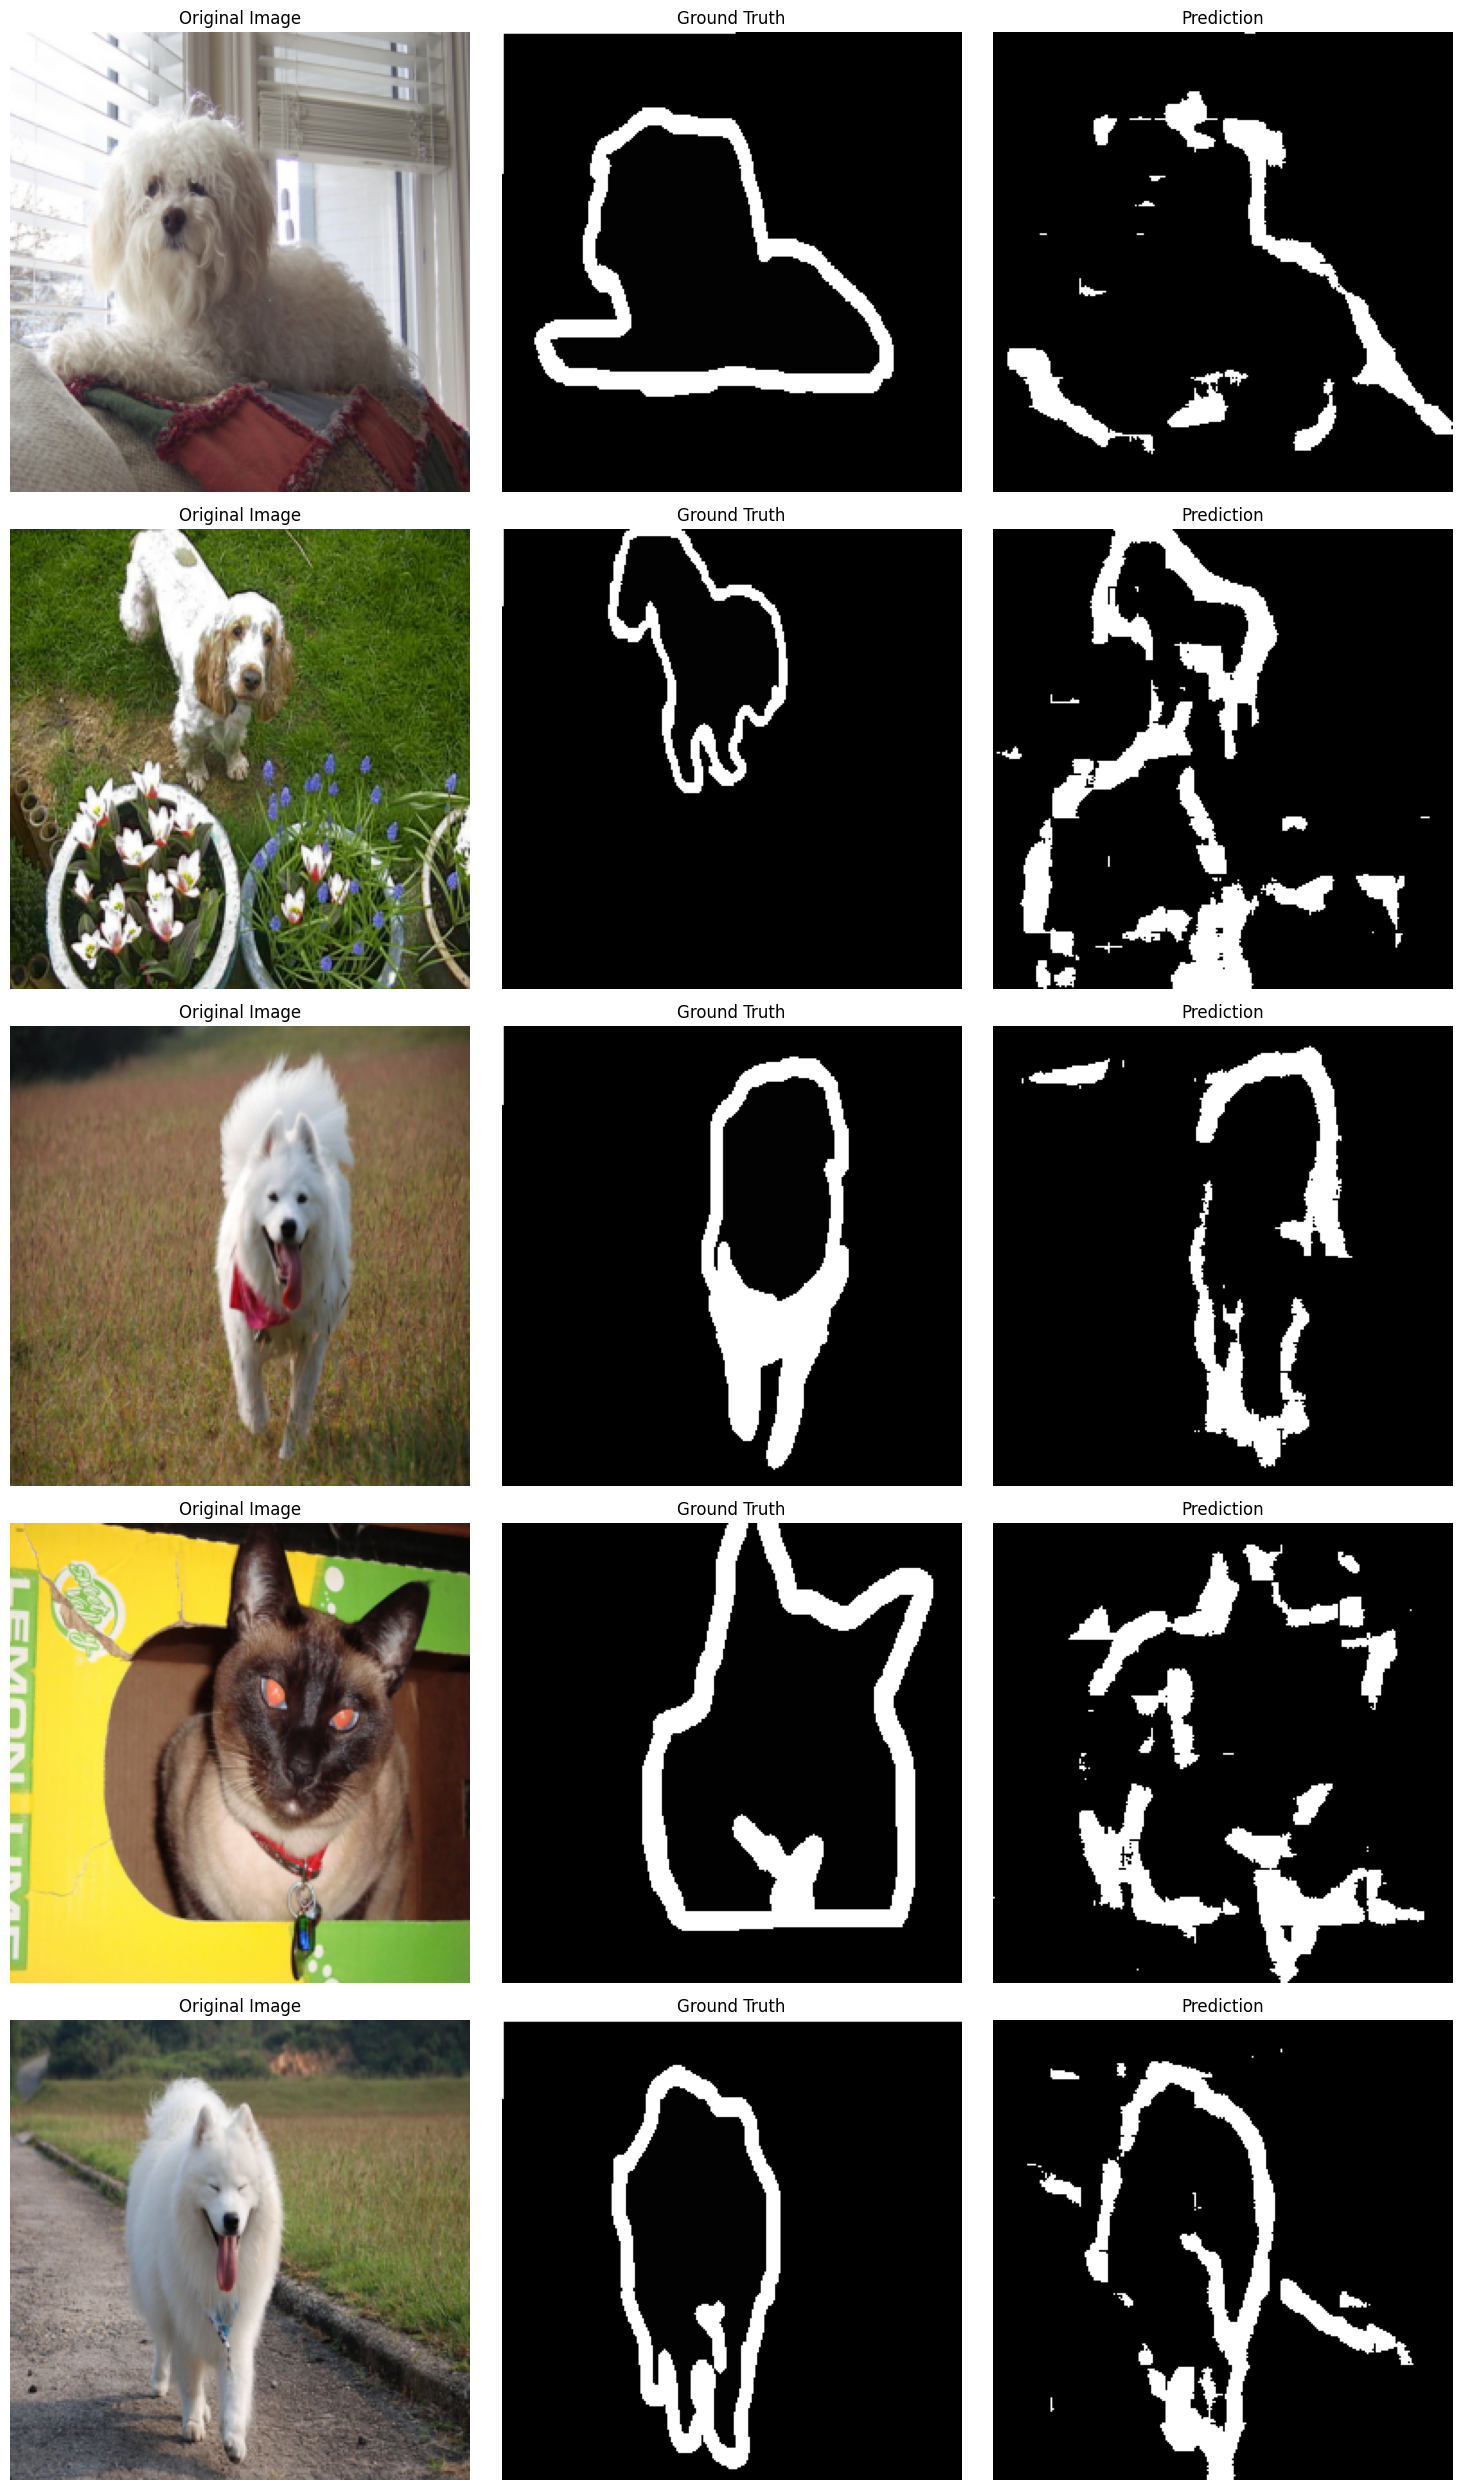

In [15]:
# Visualize results
visualize_results(segmentation_model, val_loader)